08/24/2020


In [20]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)
library(GenomicRanges)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)


library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [21]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}


In [6]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = -1) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissue==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }

    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue
#     print(design)

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(adj.P.Val)%>% arrange(desc(logFC))
    print(dim(tT_filt))
    if( max_return >0){
        tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]
    }
  return(tT_filt)
}

runSig <- function(count_df, tissues, max_return = 10000, tissue=TRUE){
    sig_loop_list = list()
    sig_loop_combined = c()
    metadata = data.frame(tissue=tissues)
    print(metadata)
    for (tissue_sel in tissues){
        print(tissue_sel)
        tT_filt = createSig(count_df[,tissues], metadata,  col_sel=tissue_sel,tissue=TRUE,max_return = max_return)
        print(dim(tT_filt))
        sig_loop_list[[tissue_sel]] = tT_filt$gene
        sig_loop_combined = c(sig_loop_combined,tT_filt$gene)

    }
    return (list('sig_loop_list'=sig_loop_list, 'sig_loop_combined'=sig_loop_combined))

}

In [7]:
save_prefix = '../data/processed/fig1/hichip/'

In [22]:
tissue_loop_df = read.csv(paste0(save_prefix,'tissue_loop_df.csv'),row.names=1)

In [23]:
all_tissue_order = c('Astrocytes','SL_D0','SL_D2','SLC_D0', 'SLC_D2','H9_D0','H9_D2', 'H9_D10','H9_D28')
time_tissue_order = c('H9_D0','H9_D2','H9_D10','H9_D28')
type0_tissue_order = c('Astrocytes','SL_D0', 'SLC_D0', 'H9_D0')
type1_tissue_order = c('Astrocytes','SL_D2', 'SLC_D2', 'H9_D2')


In [27]:
dim(tissue_loop_df)
colnames(tissue_loop_df)

[1] 10928529        9

[1] "Astrocytes" "H9_D0"      "H9_D10"     "H9_D2"      "H9_D28"    
[6] "SLC_D0"     "SLC_D2"     "SL_D0"      "SL_D2"

In [25]:
tissue_loop_df_norm = scale(tissue_loop_df, center=FALSE, scale=colSums(tissue_loop_df))*1e6 # counts per million normalized

In [26]:
colSums(tissue_loop_df_norm)

Astrocytes      H9_D0     H9_D10      H9_D2     H9_D28     SLC_D0     SLC_D2 
     1e+06      1e+06      1e+06      1e+06      1e+06      1e+06      1e+06 
     SL_D0      SL_D2 
     1e+06      1e+06

In [ ]:
# only take the highest variance rows
sd_all_tissue_loop_df_norm = apply(tissue_loop_df_norm[,all_tissue_order], 1, sd)
sd_time_tissue_loop_df_norm = apply(tissue_loop_df_norm[,time_tissue_order], 1, sd)
sd_type0_tissue_loop_df_norm = apply(tissue_loop_df_norm[,type0_tissue_order], 1, sd)
sd_type1_tissue_loop_df_norm = apply(tissue_loop_df_norm[,type1_tissue_order], 1, sd)

In [ ]:
dim(tissue_loop_df_norm)
dim(tissue_loop_df_norm[sd_time_tissue_loop_df_norm>1,])

In [12]:
# tissue_loop_df_log = log2(tissue_loop_df_norm+1e-6)
# tissue_loop_df_log_norm = as.data.frame(scale(tissue_loop_df_log, center = TRUE, scale = TRUE))


In [13]:
# annon_df = read.csv('../data/processed/fig1/rna/rna_results.csv',row.names=1)

In [14]:
# metadata = annon_df
# metadata = data.frame(tissue=time_tissue_order)
# # metadata$tissue = rownames(annon_df)
# # metadata$group = as.character(metadata$group)

# # metadata['Astrocytes','group'] = 'blue1'
# # metadata['Melanocytes','group'] = 'blue2'
# # metadata$group = as.factor(metadata$group)
# metadata

In [15]:
# ggplot(data.frame(tissue_loop_df_norm),aes(x=Astrocytes))+geom_density()

In [16]:

tissue_loop_df_norm_time_high_var = tissue_loop_df_norm[sd_time_tissue_loop_df_norm>1,time_tissue_order]



  tissue
1  H9_D0
2  H9_D2
3 H9_D10
4 H9_D28
[1] "H9_D0"


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 0 7
[1] 1 7
[1] "H9_D2"


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 14676     7
[1] 14676     7
[1] "H9_D10"
[1] 0 7
[1] 1 7
[1] "H9_D28"
[1] 15515     7
[1] 15515     7


[1] 30193

[1] 30191

# randomly sample loops

In [54]:
random_time0 = tissue_loop_df_norm[,type0_tissue_order]
dim(random_time0)
random_time0 = random_time0[rowSums(random_time0)>10,]
dim(random_time0)
random_time0 = random_time0[sample(nrow(random_time0),10000), ]
random_time0 =  scale(random_time0,center=TRUE, scale=TRUE)
random_time0[random_time0>1] = 1
random_time0[random_time0< -1] = -1

[1] 10928529        4

[1] 47202     4

pdf 
  2

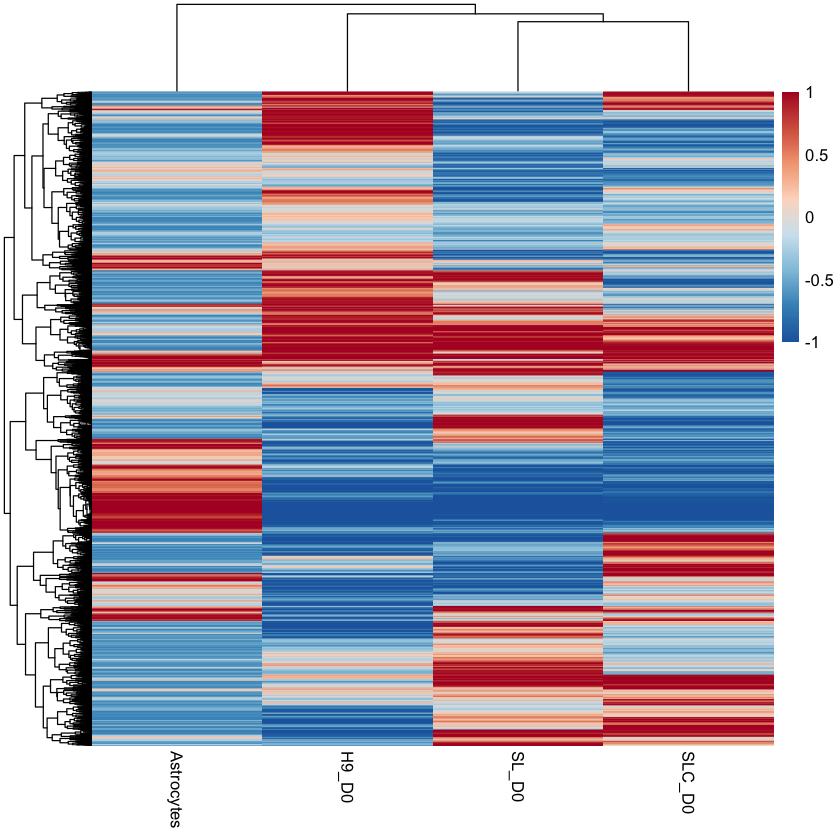

In [55]:
p = pheatmap(random_time0,#[names(sort(rowSums(time_scale)))],#tissue_loop_df_norm_time_high_var_sort,
          cluster_cols=T,
          cluster_rows=T,
         show_rownames=F,
#              annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))
save_pheatmap_pdf(p, paste0(save_prefix, 'time0_random_heatmap.pdf'),width=7,height=7)

# option 1: significance (doesn' work)

In [17]:

sig_loop = runSig(tissue_loop_df_norm_time_high_var, time_tissue_order, max_return = 20000, tissue=TRUE)
length(sig_loop$sig_loop_combined)
sig_loop_combined = unique(sort(sig_loop$sig_loop_combined))
sig_loop_combined <- sig_loop_combined[!is.na(sig_loop_combined)]
length(sig_loop_combined)

dim(tissue_loop_df_norm_time_high_var)

[1] 203097      4

In [18]:
tissue_loop_sig = tissue_loop_df_norm_time_high_var[sig_loop_combined,]
dim(tissue_loop_sig)
tissue_loop_sig[tissue_loop_sig>3] = 3
tissue_loop_sig[tissue_loop_sig< -3] = -3
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,max)>0 ,]
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,sd)>0.2 ,]
select_loops = rownames(tissue_loop_sig)
dim(tissue_loop_sig)

[1] 30191     4

[1] 30191     4

In [19]:
# pheatmap(tissue_loop_df_norm_time_high_var,
#          show_rownames=F,
#          color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

In [ ]:
# p_10000 = pheatmap(tissue_loop_sig,
#              cluster_rows=T,
#              cluster_cols=F,
#                 show_rownames=F,
# #              annotation_col=annon_df,
#                color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))


In [133]:
# save_pheatmap_png( p_10000, paste0(save_prefix, 'heatmap_top10000.png'), height=2000,width=2000,res=300)

pdf 
  2

# option 2: time slope (for the time option) look at looping trajectories

In [ ]:
# ggplot(data.frame(tissue_loop_df_norm_time_high_var), aes(x=as.numeric(H9_D0)))+geom_density()
slope  <-  function(x){
    if(all(is.na(x)))
        # if x is all missing, then lm will throw an error that we want to avoid
        return(NA)
    else
        model = lm(I(1:length(x))~x)
        return(model$coefficients[2])
        # fstat = summary(m)$fstatistic
        # p_f = pf(fstat[1],fstat[2],fstat[3],lower.tail=FALSE)
        # return (list( 'coef' = model$coefficients[2], 
        #               'pval' = p_f,
        #               'fstat' = fstat[1]))
  }




In [ ]:
time_slope = apply(tissue_loop_df_norm_time_high_var, 1, slope)

In [ ]:
ggplot(data.frame(time_slope),aes(x=time_slope))+geom_density()

In [ ]:
tissue_loop_df_norm_time_high_var

In [29]:
time_slope = sort(time_slope)
diff_time_slope = time_slope[(time_slope>.6) | (time_slope< (-.6))]
length(time_slope)
length(diff_time_slope)

[1] 203097

[1] 52687

In [30]:
# get count values
tissue_loop_df_norm_time_high_var_sort = tissue_loop_df_norm_time_high_var[names(diff_time_slope),]
dim(tissue_loop_df_norm_time_high_var_sort)

[1] 52687     4

In [46]:
# scale and truncate 
tissue_loop_df_norm_time_high_var_sort_scale = scale(tissue_loop_df_norm_time_high_var_sort,center=TRUE, scale=TRUE)
tissue_loop_df_norm_time_high_var_sort_scale[tissue_loop_df_norm_time_high_var_sort_scale>1] = 1
summary(tissue_loop_df_norm_time_high_var_sort_scale)
dim(tissue_loop_df_norm_time_high_var_sort_scale)

# trime
tissue_loop_df_norm_time_high_var_sort_scale_min = apply(tissue_loop_df_norm_time_high_var_sort_scale, 1,min)
tissue_loop_df_norm_time_high_var_sort_scale_max = apply(tissue_loop_df_norm_time_high_var_sort_scale, 1,max)

time_scale = data.frame(tissue_loop_df_norm_time_high_var_sort_scale[(tissue_loop_df_norm_time_high_var_sort_scale_min< (-.5)) & (tissue_loop_df_norm_time_high_var_sort_scale_max>0.5),])
dim(time_scale)


     H9_D0              H9_D2             H9_D10            H9_D28        
 Min.   :-1.00187   Min.   :-0.7130   Min.   :-0.5871   Min.   :-1.09039  
 1st Qu.:-1.00187   1st Qu.:-0.7130   1st Qu.:-0.5871   1st Qu.:-1.09039  
 Median :-0.21284   Median :-0.4352   Median :-0.5871   Median : 0.13727  
 Mean   :-0.07803   Mean   :-0.1538   Mean   :-0.1564   Mean   :-0.06764  
 3rd Qu.: 0.83921   3rd Qu.: 0.2972   3rd Qu.: 0.2272   3rd Qu.: 0.95571  
 Max.   : 1.00000   Max.   : 1.0000   Max.   : 1.0000   Max.   : 1.00000  

[1] 52687     4

[1] 50086     4

In [48]:
 paste0(save_prefix, 'time_heatmap_csv')
write.csv(time_scale, paste0(save_prefix, 'time_heatmap_csv'))

[1] "../data/processed/fig1/hichip/time_heatmap_csv"

In [16]:
time_scale = read.csv(paste0(save_prefix, 'time_heatmap_csv'),row.names=1)
head(time_scale)
dim(time_scale)

,H9_D0,H9_D2,H9_D10,H9_D28
,<dbl>,<dbl>,<dbl>,<dbl>
chr14_23490000_23495000::chr14_23510000_23515000,1.0000000,1,1.0000000,-0.6811734
chr5_89790000_89795000::chr5_89810000_89815000,1.0000000,1,1.0000000,-0.6811734
chr11_124525000_124530000::chr11_124660000_124665000,0.5761985,1,0.2271818,-1.0903932
chr3_113980000_113985000::chr3_114005000_114010000,0.5761985,1,0.2271818,-1.0903932
chr22_36980000_36985000::chr22_37085000_37090000,0.5761985,1,0.2271818,-1.0903932
chr22_36985000_36990000::chr22_37085000_37090000,0.5761985,1,0.2271818,-1.0903932


[1] 50086     4

pdf 
  2

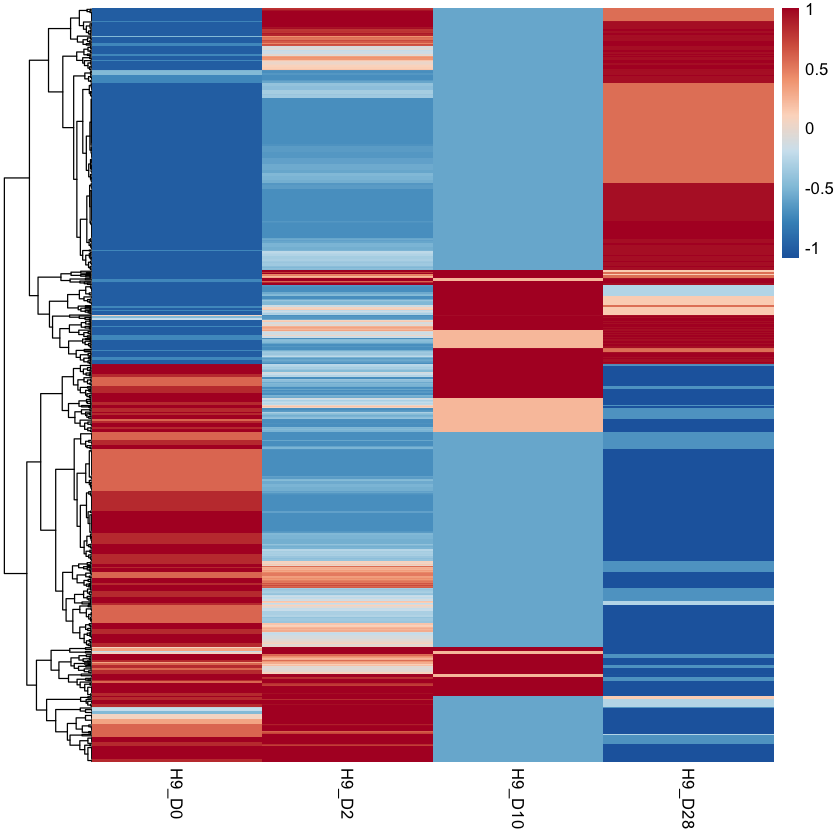

In [19]:
#manually arrange rows
# time_scale = arrange(time_scale,H9_D0, H9_D28)
# sample rows
time_scale = time_scale[sample(nrow(time_scale), 800), ]
p = pheatmap(time_scale,#[names(sort(rowSums(time_scale)))],#tissue_loop_df_norm_time_high_var_sort,
          cluster_cols=F,
          cluster_rows=T,
         show_rownames=F,
#              annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))
save_pheatmap_pdf(p, paste0(save_prefix, 'time_heatmap.pdf'),width=7,height=7)

# getting gene signatures

In [42]:
# c('SL_D0','SL_D2','SLC_D0', 'SLC_D2','H9_D0','H9_D2','H9_D10','H9_D28')
H9_D0_loops= sig_loop_list$H9_D0[ sig_loop_list$H9_D0 %in% select_loops]
length(H9_D0_loops)
H9_D2_loops= sig_loop_list$H9_D2[ sig_loop_list$H9_D2 %in% select_loops]
length(H9_D2_loops)
H9_D10_loops= sig_loop_list$H9_D10[ sig_loop_list$H9_D10 %in% select_loops]
length(H9_D10_loops)
H9_D28_loops= sig_loop_list$H9_D28[ sig_loop_list$H9_D28 %in% select_loops]
length(H9_D28_loops)
SL_D0_loops  = sig_loop_list$SL_D0[ sig_loop_list$SL_D0 %in% select_loops]
length(SL_D0_loops)
SL_D2_loops  = sig_loop_list$SL_D2[ sig_loop_list$SL_D2 %in% select_loops]
length(SL_D2_loops)
SLC_D0_loops  = sig_loop_list$SLC_D0[ sig_loop_list$SLC_D0 %in% select_loops]
length(SLC_D0_loops)
SLC_D2_loops  = sig_loop_list$SLC_D2[ sig_loop_list$SLC_D2 %in% select_loops]
length(SCL_D2_loops)
all_loops = rownames(tissue_loop_df_norm)
length(all_loops)

[1] 10000

[1] 10000

[1] 10000

[1] 10000

[1] 10000

[1] "d;"

[1] 0

[1] 10000

ERROR: Error in eval(expr, envir, enclos): object 'SCL_D2_loops' not found


In [58]:
get_genes = function(loops){
    df = data.frame("loop"=loops)%>%
        separate(loop, c('source','target'), sep='::')
    df_anc <- data.frame("anchor" = unique(c(df[,"source"], df[,"target"]))) %>%
        separate(anchor, c("chr", "start", "stop"), sep='_')
    df_gr = makeGRangesFromDataFrame(df_anc)#                         seqnames.field=c("seqnames", "seqname",
    df_gr_anno = annotatePeak(df_gr, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)

    df_gr_anno <- as.data.frame(df_gr_anno)
    df_gr_anno$symbol <- mapIds(org.Hs.eg.db, keys=df_gr_anno$geneId, column="SYMBOL", keytype="ENTREZID", multiVals="first")

    genes = sort(unique(df_gr_anno$symbol))
    return(genes)
}

In [98]:
idx_days_gene= list()
all_genes =c()
idx_days_entrez = list()
for (day in colnames(time_scale)){
    idx_day = rownames(time_scale)[time_scale[[day]]>0.95]
    print(day)
    print(length(idx_day))

    genes = get_genes(idx_day)
    print(length(unique(sort(genes))))
    idx_days_gene[[day]] = unique(sort(genes))
    all_genes  = c(all_genes,idx_days_gene[[day]] )
    write.table(unique(sort(genes)), paste0(save_prefix,'time_genes_',day,'.csv'),row.names=FALSE,col.names=FALSE)
    
    idx_day_entrez = bitr(unique(sort(genes)), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    idx_days_entrez[[day]] = unique(sort(idx_day_entrez))
    print(length(idx_days_entrez[[day]] ))

}
length(all_genes)

[1] "H9_D0"
[1] 9903
>> preparing features information...		 2020-08-25 08:18:43 
>> identifying nearest features...		 2020-08-25 08:18:43 
>> calculating distance from peak to TSS...	 2020-08-25 08:18:44 
>> assigning genomic annotation...		 2020-08-25 08:18:44 
>> assigning chromosome lengths			 2020-08-25 08:18:45 
>> done...					 2020-08-25 08:18:45 


'select()' returned 1:1 mapping between keys and columns



[1] 7294


'select()' returned 1:many mapping between keys and columns



[1] 7295
[1] "H9_D2"
[1] 6986
>> preparing features information...		 2020-08-25 08:18:46 
>> identifying nearest features...		 2020-08-25 08:18:46 
>> calculating distance from peak to TSS...	 2020-08-25 08:18:46 
>> assigning genomic annotation...		 2020-08-25 08:18:46 
>> assigning chromosome lengths			 2020-08-25 08:18:48 
>> done...					 2020-08-25 08:18:48 


'select()' returned 1:1 mapping between keys and columns



[1] 4449


'select()' returned 1:many mapping between keys and columns



[1] 4451
[1] "H9_D10"
[1] 9179
>> preparing features information...		 2020-08-25 08:18:49 
>> identifying nearest features...		 2020-08-25 08:18:49 
>> calculating distance from peak to TSS...	 2020-08-25 08:18:49 
>> assigning genomic annotation...		 2020-08-25 08:18:49 
>> assigning chromosome lengths			 2020-08-25 08:18:51 
>> done...					 2020-08-25 08:18:51 


'select()' returned 1:1 mapping between keys and columns



[1] 7531


'select()' returned 1:many mapping between keys and columns



[1] 7532
[1] "H9_D28"
[1] 14263
>> preparing features information...		 2020-08-25 08:18:51 
>> identifying nearest features...		 2020-08-25 08:18:51 
>> calculating distance from peak to TSS...	 2020-08-25 08:18:52 
>> assigning genomic annotation...		 2020-08-25 08:18:52 
>> assigning chromosome lengths			 2020-08-25 08:18:54 
>> done...					 2020-08-25 08:18:54 


'select()' returned 1:1 mapping between keys and columns



[1] 6417


'select()' returned 1:1 mapping between keys and columns



[1] 6417


[1] 25691

In [84]:
length(all_genes)
unique_genes = rownames(table(all_genes)==1)[table(all_genes)==1]
length(unique_genes)



[1] 25691

[1] 5159

In [88]:
idx_days_gene_unique_entrez = list()
for (day in names(idx_days_gene)){
    print(day)
    genes = idx_days_gene[[day]] 
    print(length(genes))
    unique_g = genes[genes %in% unique_genes]
    print(length(unique_g))
    write.table(sort(unique_g), paste0(save_prefix,'time_unique_genes_',day,'.csv'),row.names=FALSE,col.names=FALSE)
    
    idx_day_entrez = bitr(unique_g, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    
    idx_days_gene_unique_entrez[[day]] = unique(sort(idx_day_entrez))
    print(length(unique(sort(idx_day_entrez))))
    
}

[1] "H9_D0"
[1] 7294
[1] 1768


'select()' returned 1:1 mapping between keys and columns



[1] 1768
[1] "H9_D2"
[1] 4449
[1] 524


'select()' returned 1:many mapping between keys and columns



[1] 525
[1] "H9_D10"
[1] 7531
[1] 1231


'select()' returned 1:1 mapping between keys and columns



[1] 1231
[1] "H9_D28"
[1] 6417
[1] 1636


'select()' returned 1:1 mapping between keys and columns



[1] 1636


## gene signature checking

In [103]:
save_prefix = '../data/processed/fig1/hichip/time_all_'


In [ ]:
ck_reactome_90 <- compareCluster(geneCluster = idx_days_entrez, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups.csv"))

In [ ]:
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups.pdf"),height=7, width=10)

In [104]:
ck_go_bp <- compareCluster(geneCluster = idx_days_entrez, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 1,
                                qvalueCutoff  = 1,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05.csv'))

# ck_go_mf <- compareCluster(geneCluster = idx_days_gene_unique_entrez, fun = "enrichGO", 
#                                 pAdjustMethod='BH', 
#                                 pvalueCutoff  = 0.05,
#                                 qvalueCutoff  = 0.05,
#                                 OrgDb='org.Hs.eg.db', 
#                                 ont = "MF",
#                                 readable=TRUE)                              
# head(as.data.frame(ck_go_mf))
# write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05.csv'))


# ck_go_cc <- compareCluster(geneCluster = idx_days_gene_unique_entrez, fun = "enrichGO", 
#                                 pAdjustMethod='BH', 
#                                 pvalueCutoff  = 0.05,
#                                 qvalueCutoff  = 0.05,
#                                 OrgDb='org.Hs.eg.db', 
#                                 ont = "CC",
#                                 readable=TRUE)
# head(as.data.frame(ck_go_cc))
# write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05.csv'))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,H9_D0,GO:0018105,peptidyl-serine phosphorylation,138/6043,299/18670,3.876198e-07,0.002502861,0.002249011,AKT3/SH2D3C/SH2D3A/SGK2/HIPK3/AKAP9/RAMP3/HAX1/MAD2L2/PLK2/IL24/CHEK2/STK38/CHUK/LRRK2/CREBL2/CSF3/CSNK1D/CSNK1G2/CSNK2A1/CSNK2A2/CNKSR3/GRK2/DGKQ/DMPK/DRD1/DYRK1A/EIF4G1/MARK2/STK32A/AKT2/ERN1/INPP5F/DKK1/STK38L/SMG1/MAST2/GPD1L/TSSK2/MTOR/GAS6/GCG/INPP5J/STK39/STK32C/TSSK4/MKNK2/GSK3B/PKN3/HCLS1/HSP90AB1/IFNE/IFNA1/IFNA2/IFNA5/IFNA6/IFNA21/IFNB1/IFNW1/IKBKB/IL6/ILK/ARAF/MAST4/SBK1/LIF/MARK1/MAP3K10/NOS1/ATP2B4/OSM/PAK1/PDGFB/PFN2/PIK3CA/PLCL1/ATR/STK32B/PRKAA2/PRKACA/PRKACB/PRKCB/PRKCH/PKN1/PRKCQ/PRKCZ/PRKG2/MAPK1/MAPK3/MAPK9/MAPK13/IFNK/PTGS2/RAF1/ROCK1/BDKRB2/NSD1/SGK1/PINK1/WNK1/CAPRIN2/SRC/STK4/TDGF1/TGFBR2/TOP1/TTK/UCN/VRK2/WNT5A/MAP3K12/MAPKAPK3/MAPKAP1/GGNBP2/CALCR/HMGA2/TCL1A/CAMK4/CAMK2A/CDC7/TSSK6/ULK1/BCAR3/DYRK3/TTBK1/CAMK1/DOCK7/MKNK1/CAV1/TNKS/RIPK2/WNT3A/DCLK1/ROCK2/CD44/TCL1B/IKBKE/RASSF2,138
2,H9_D0,GO:0018209,peptidyl-serine modification,145/6043,322/18670,1.173350e-06,0.003788160,0.003403950,AKT3/SH2D3C/SH2D3A/SGK2/HIPK3/AKAP9/RAMP3/HAX1/MAD2L2/PLK2/IL24/CHEK2/STK38/CHUK/GALNT13/LRRK2/CREBL2/PARP1/CSF3/CSNK1D/CSNK1G2/CSNK2A1/CSNK2A2/CNKSR3/GRK2/DGKQ/DMPK/DRD1/DYRK1A/EIF4G1/MARK2/STK32A/AKT2/ERN1/INPP5F/DKK1/STK38L/SMG1/MAST2/GPD1L/TSSK2/MTOR/GALNT1/GAS6/GCG/INPP5J/STK39/STK32C/TSSK4/MKNK2/GSK3B/PKN3/HCLS1/HSP90AB1/IFNE/IFNA1/IFNA2/IFNA5/IFNA6/IFNA21/IFNB1/IFNW1/IKBKB/IL6/ILK/ARAF/MAST4/SBK1/LIF/MARK1/MAP3K10/NOS1/ATP2B4/OSM/PAK1/SPOCK3/PDGFB/PFN2/PIK3CA/PLCL1/ATR/STK32B/PRKAA2/PRKACA/PRKACB/PRKCB/PRKCH/PKN1/PRKCQ/PRKCZ/PRKG2/MAPK1/MAPK3/MAPK9/MAPK13/IFNK/PTGS2/GALNT16/RAF1/ROCK1/BDKRB2/NSD1/SGK1/PINK1/WNK1/CAPRIN2/SRC/STK4/TDGF1/TGFBR2/TOP1/TTK/UCN/VRK2/WNT5A/MAP3K12/MAPKAPK3/MAPKAP1/GGNBP2/CALCR/HMGA2/TCL1A/CAMK4/CAMK2A/CDC7/TSSK6/ULK1/BCAR3/DYRK3/TTBK1/NAA11/CAMK1/DOCK7/MKNK1/CAV1/TNKS/GALNT4/RIPK2/WNT3A/DCLK1/ROCK2/CD44/TCL1B/IKBKE/RASSF2,145
3,H9_D0,GO:0007156,homophilic cell adhesion via plasma membrane adhesion molecules,83/6043,168/18670,3.119265e-06,0.006338647,0.005695756,CDH5/CDH9/CDH11/CDH15/CDH17/FAT3/VSTM2L/EMB/DSG4/DSCAM/DSG1/DSG3/CELSR3/SDK1/CLSTN1/IGSF9B/PLXNB2/PTPN23/PCDHB5/NPTN/CDH20/PCDHB1/ANXA3/ITGB1/PCDHGC3/PCDH7/PIK3CB/SDK2/PCDHGC5/PCDHGB7/PCDHGB6/PCDHGB5/PCDHGB3/PCDHGB2/PCDHGB1/PCDHGA11/PCDHGA9/PCDHGA6/PCDHGA5/PCDHB14/PCDHB13/PCDHB11/PCDHB10/PCDHB7/PCDHB4/PCDHB3/PCDHB2/PCDHAC2/PCDHAC1/PCDHA13/PCDHA12/PCDHA10/PCDHA8/PCDHA6/PCDHA5/PCDHA4/PCDHA3/PCDHA2/PCDHA1/DSCAML1/PCDH19/PCDH10/PCDHB16/CADM3/PTPRM/PVR/NECTIN1/CDH26/ROBO1/CDH23/ROBO3/CDH22/CNTN2/HMCN1/IGSF21/PCDHGB4/NEXN/CDHR1/MYOT/CELSR1/PCDHGA8/CLSTN3/PCDHA9,83
4,H9_D0,GO:0010975,regulation of neuron projection development,209/6043,499/18670,3.926682e-06,0.006338647,0.005695756,UST/PLXNC1/ADAM10/KATNB1/OLFM1/STK25/SEMA6C/SEMA4D/SEMA4B/CIB1/AVIL/TBR1/CFL1/PLK2/CHN1/STX1B/RNF157/ARHGAP33/ACAP3/LRRK2/SEZ6/PLK5/CNTF/CRMP1/CHODL/RTN4RL1/CTNNA2/TTL/CUX1/AP2A1/DBN1/PLPPR5/DPYSL2/DPYSL3/DSCAM/DVL1/DVL3/LPAR1/EFNB3/MEGF8/MARK2/CTTN/EPHB2/EPHB3/EZH2/SDK1/FES/FGF13/FGFR1/INPP5F/SHANK2/DKK1/ZSWIM8/SETX/HECW1/SARM1/FSTL4/RAP1GAP2/SPART/KANK1/CYFIP1/COBL/MINAR1/DENND5A/CAMSAP2/CUX2/NEDD4L/OBSL1/CRTC1/ADNP/NCS1/MACF1/ZMYND8/PLXNB2/MTOR/FYN/NEGR1/GAK/SS18L1/DNM3/FBXW8/NPTN/INPP5J/GOLGA4/GRID2/GRN/DBNL/GRIN1/ARHGAP35/MYLIP/GSK3B/ANAPC2/PACSIN1/APBB1/IFRD1/TUBB2B/APOE/RTN4RL2/ILK/ITGA6/ITPKA/DRAXIN/ARF1/ARF6/RHOA/LGALS1/LRP4/LTK/MIR200C/MAG/MAP6/MARK1/MOV10/MIR133B/MT3/NKX6-1/NME1/NTRK1/PAK1/ITSN2/PAK3/SHANK1/ATP8A2/PLXNA1/PLXNA2/PMP22/C21orf91/SEMA4C/YTHDF1/FEZF2/PPP2R5B/PPP3CA/TMEM30A/MAP2K1/KLK6/RGMA/RTN4/SMURF1/PTK2/KIDINS220/HECW2/PTK6/PTK7/ZSWIM5/ZSWIM6/LRRC4C/CPNE5/ADGRB3/PTPN9/PTPRF/RAP2A/CACNG7/REG1A/RGS2/RIT2/ROBO1/RYK/CXCL12/SEMA3F/SEMA4A/RAB17/ITSN1/GORASP1/CREB3L2/SKIL/RTN4R/BMP7/CAPRIN2/SPP1/SRF/SYT1/CNTN2/NR2F1/THY1/TRPC5/TSC1/UBE3A/WNT5A/LRP8/SEMA3B/SEMA6D/MOB2/FBXO38/ITM2C/FZD1/FZD4/ANKRD27/S

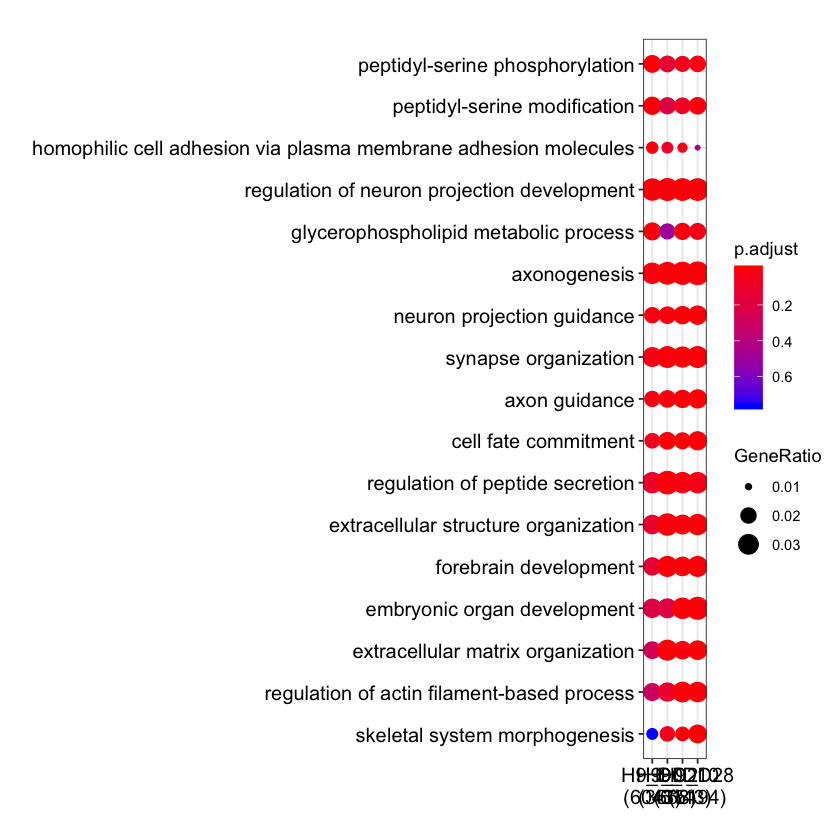

In [105]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups.pdf"),height=7, width=10)
# dotplot(ck_go_mf)
# ggsave(file = paste0(save_prefix, "ck_go_mf_groups.pdf"),height=7, width=10)
# dotplot(ck_go_cc)
# ggsave(file = paste0(save_prefix, "ck_go_cc_groups.pdf"),height=7, width=10)

In [106]:
save_prefix = '../data/processed/fig1/hichip/time_unique_'


In [107]:
ck_reactome_90 <- compareCluster(geneCluster = idx_days_gene_unique_entrez, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups.csv"))

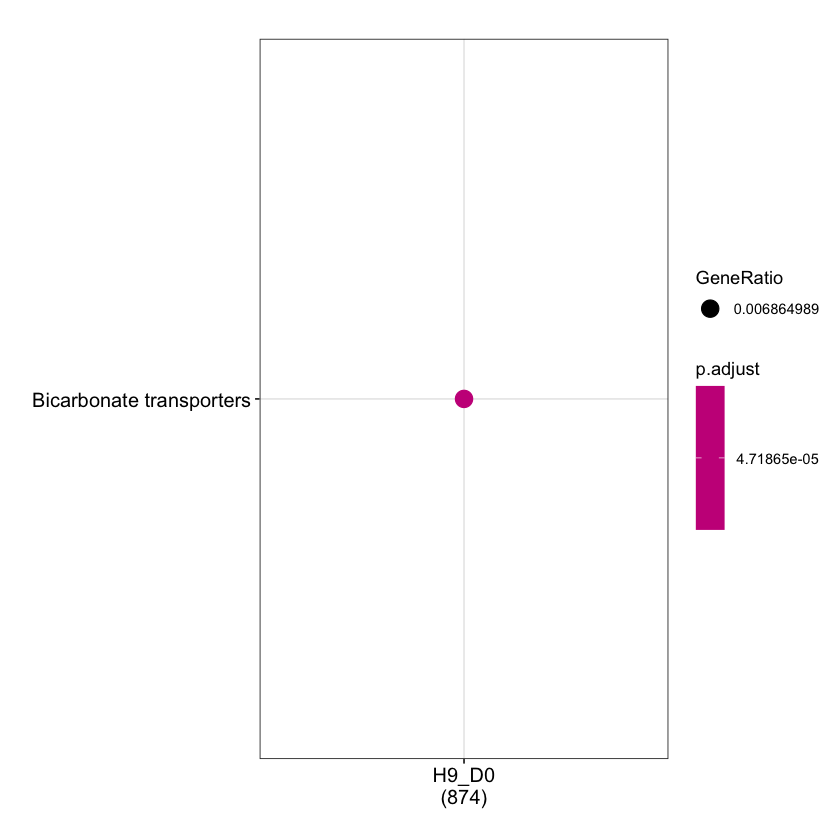

In [101]:
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups.pdf"),height=7, width=10)

In [108]:
ck_go_bp <- compareCluster(geneCluster = idx_days_gene_unique_entrez, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 1,
                                qvalueCutoff  = 1,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05.csv'))

# ck_go_mf <- compareCluster(geneCluster = idx_days_gene_unique_entrez, fun = "enrichGO", 
#                                 pAdjustMethod='BH', 
#                                 pvalueCutoff  = 0.05,
#                                 qvalueCutoff  = 0.05,
#                                 OrgDb='org.Hs.eg.db', 
#                                 ont = "MF",
#                                 readable=TRUE)                              
# head(as.data.frame(ck_go_mf))
# write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05.csv'))


# ck_go_cc <- compareCluster(geneCluster = idx_days_gene_unique_entrez, fun = "enrichGO", 
#                                 pAdjustMethod='BH', 
#                                 pvalueCutoff  = 0.05,
#                                 qvalueCutoff  = 0.05,
#                                 OrgDb='org.Hs.eg.db', 
#                                 ont = "CC",
#                                 readable=TRUE)
# head(as.data.frame(ck_go_cc))
# write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05.csv'))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,H9_D0,GO:0098742,cell-cell adhesion via plasma-membrane adhesion molecules,38/1426,273/18670,0.0002322512,0.445537,0.4451035,CDH9/CDH17/CEACAM8/MMP24/EMB/CLDN3/DSCAM/DSG3/CLSTN1/CRB1/PTPN23/IL10/ITGB1/EPCAM/MAG/PCDHGB7/PCDHGB1/PCDHB2/PCDHAC1/PCDHA13/PCDHA10/PCDHA8/PCDHA5/PCDHA2/PCDHA1/PCDH10/PCDHB16/PVR/WNK1/TGFBR2/UMOD/PCDHGB4/CBLN1/ACVR1/CLDN12/CLDN1/NEXN/PCDHA9,38
2,H9_D0,GO:0006260,DNA replication,38/1426,274/18670,0.0002502568,0.445537,0.4451035,RAD50/ATG7/DBF4/WDHD1/CHEK2/ESCO2/SDE2/WAPL/ORC3/MCM9/STOML2/HRAS/STRA8/MAS1/NASP/NFIX/RTF2/POLB/ATR/CHTF8/TIPIN/FANCM/BARD1/RECQL/RFC2/BLM/MAP2K4/SETMAR/BRCA2/TERF1/TOP3A/TP53/UCN/MCMBP/SLX4/TICRR/HELB/RECQL5,38
3,H9_D0,GO:0032507,maintenance of protein location in cell,15/1426,74/18670,0.0004060919,0.445537,0.4451035,TOPORS/KDELR1/TAPT1/SYNE1/ANK3/JUP/PFN4/SHANK1/BARD1/PINK1/SPAG4/ANKRD13C/TAF3/TMSB10/CD4,15
4,H9_D0,GO:0034504,protein localization to nucleus,36/1426,262/18670,0.0004295346,0.445537,0.4451035,SNUPN/TOPORS/IPO8/CCT2/DRD1/PIKFYVE/SYNE1/KPNA6/CNEP1R1/APPL1/GSK3B/JUP/KPNA2/IPO5/CHCHD10/NUP88/NVL/MED1/APPL2/PPP3CA/FERMT1/INTS13/NXT2/PTGS2/BARD1/SMO/TP53/XPA/XPO1/SESN2/TAF3/MBTPS1/DCLK1/MFHAS1/IPO13/NUP93,36
5,H9_D0,GO:0032731,positive regulation of interleukin-1 beta production,12/1426,52/18670,0.0004401058,0.445537,0.4451035,TRIM16/CARD8/PANX1/HSPB1/IFI16/LILRA5/LPL/NLRP2/INAVA/TYROBP/CASP1/CASP8,12
6,H9_D0,GO:0006275,regulation of DNA replication,19/1426,108/18670,0.0004990808,0.445537,0.4451035,ATG7/DBF4/CHEK2/ESCO2/WAPL/STOML2/HRAS/MAS1/ATR/CHTF8/TIPIN/RFC2/BLM/MAP2K4/BRCA2/TERF1/TP53/UCN/TICRR,19


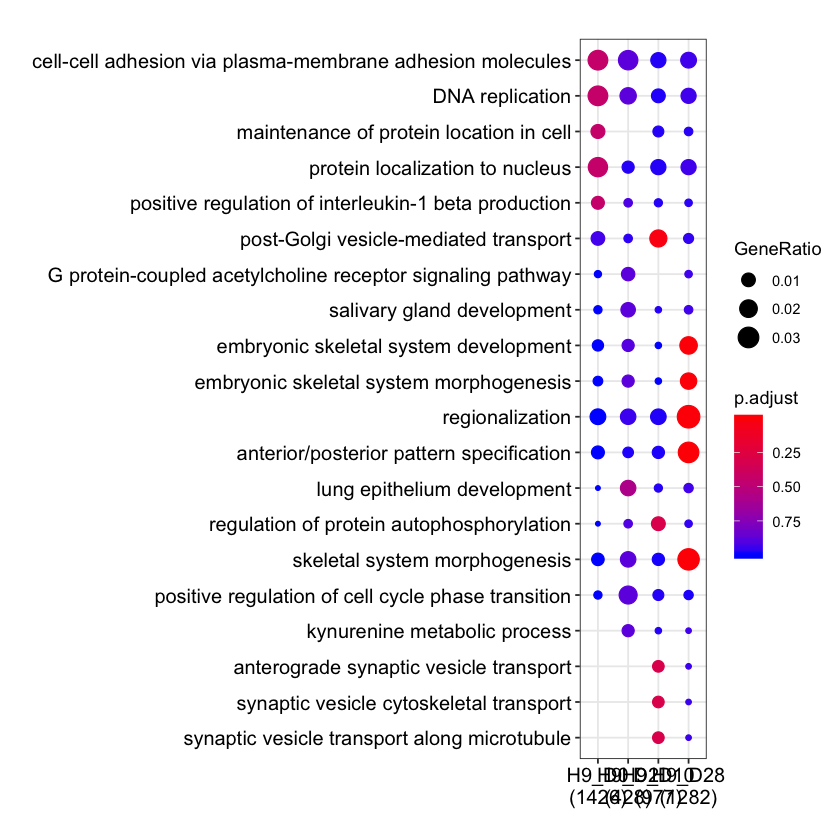

In [109]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups.pdf"),height=7, width=10)
# dotplot(ck_go_mf)
# ggsave(file = paste0(save_prefix, "ck_go_mf_groups.pdf"),height=7, width=10)
# dotplot(ck_go_cc)
# ggsave(file = paste0(save_prefix, "ck_go_cc_groups.pdf"),height=7, width=10)

manually edit `ck_go_bp_05.csv` and then reload

for selected go terms

TODO NOT DONE!

In [23]:
ck_go_bp = read.csv(paste0(save_prefix,'ck_go_bp_05.csv'),row.names=1)
head(ck_go_bp)
dim(ck_go_bp)
ck_go_bp <- new("compareClusterResult",
               compareClusterResult = ck_go_bp,
               geneClusters = cluster_all,
               .call = match.call(expand.dots=TRUE)
               )
ck_go_bp@fun <- 'enrichGO'


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,purple,GO:0008544,epidermis development,129/2126,464/18670,7.904353e-23,4.875405e-19,3.904751e-19,ABCA12/ANXA1/APCDD1/ATP2A2/BCL2/BNC1/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FABP5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LAMB3/LAMC2/LCE5A/LELP1/LGR4/LRTOMT/MYO5A/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SFN/SLC4A7/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,129
2,purple,GO:0070268,cornification,54/2126,112/18670,2.694018e-22,8.308352e-19,6.654225e-19,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/PERP/PKP1/RPTN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH,54
3,purple,GO:0030216,keratinocyte differentiation,92/2126,305/18670,3.698981e-19,7.605106e-16,6.090989e-16,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/UGCG/YAP1/ZFP36L1,92
4,purple,GO:0043588,skin development,113/2126,419/18670,5.112409e-19,7.883335e-16,6.313826e-16,ABCA12/ANXA1/APCDD1/BCL2/CD109/CDH3/CELSR1/CLDN1/COL5A2/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LGR4/MET/MYO5A/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TCHH/TP63/UGCG/YAP1/ZFP36L1,113
5,purple,GO:0009913,epidermal cell differentiation,99/2126,358/18670,1.297138e-17,1.600149e-14,1.281572e-14,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LRTOMT/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SLC4A7/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,99
6,purple,GO:0034330,cell junction organization,83/2126,290/18670,6.407880e-16,6.587300e-13,5.275821e-13,ACTN4/ANK2/ARF6/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH20/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CORO2B/CTNND1/DLC1/DLG5/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FSCN1/GJA1/GJB2/GRHL1/GRHL2/ITGA2/ITGA5/ITGA6/JUP/KIFC3/KRT14/KRT5/LAMB3/LAMC1/LA

[1] 4326   10

In [24]:
data.frame(ck_go_bp)%>%
    group_by(Description)%>%
    summarise(count=n())%>%
    dim()

[1] 2373    2

In [56]:
head(ck_go_bp)

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0008544,epidermis development,129/2126,464/18670,7.904353e-23,4.875405e-19,3.904751e-19,ABCA12/ANXA1/APCDD1/ATP2A2/BCL2/BNC1/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FABP5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LAMB3/LAMC2/LCE5A/LELP1/LGR4/LRTOMT/MYO5A/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SFN/SLC4A7/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,129
2,purple,GO:0070268,cornification,54/2126,112/18670,2.694018e-22,8.308352e-19,6.654225e-19,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/PERP/PKP1/RPTN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH,54
3,purple,GO:0030216,keratinocyte differentiation,92/2126,305/18670,3.698981e-19,7.605106e-16,6.090989e-16,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/UGCG/YAP1/ZFP36L1,92
4,purple,GO:0043588,skin development,113/2126,419/18670,5.112409e-19,7.883335e-16,6.313826e-16,ABCA12/ANXA1/APCDD1/BCL2/CD109/CDH3/CELSR1/CLDN1/COL5A2/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LGR4/MET/MYO5A/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TCHH/TP63/UGCG/YAP1/ZFP36L1,113
5,purple,GO:0009913,epidermal cell differentiation,99/2126,358/18670,1.297138e-17,1.600149e-14,1.281572e-14,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LRTOMT/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SLC4A7/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,99
6,purple,GO:0034330,cell junction organization,83/2126,290/18670,6.407880e-16,6.587300e-13,5.275821e-13,ACTN4/ANK2/ARF6/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH20/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CORO2B/CTNND1/DLC1/DLG5/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FSCN1/GJA1/GJB2/GRHL1/GRHL2/ITGA2/ITGA5/ITGA6/JUP/KIFC3/KRT14/KRT5/LAMB3/LAMC1/LA

In [36]:
match.call(expand.dots=TRUE)

match.call(expand.dots = TRUE)

In [31]:
ck_go_bp_sel = read.csv(paste0(save_prefix,'ck_go_bp_05_sel.csv'),row.names=1)
head(ck_go_bp_sel)
dim(ck_go_bp_sel)
ck_go_bp_sel <- new("compareClusterResult",
               compareClusterResult = ck_go_bp_sel,
               geneClusters = cluster_all,
               .call = match.call(expand.dots=TRUE)
               )
ck_go_bp_sel@fun <- 'enrichGO'


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,blue1,GO:0007411,axon guidance,85/2538,276/18670,7.97000e-14,1.840000e-11,1.340000e-11,APBB2/APP/ARHGAP35/ARX/BMP7/BMPR1B/BOC/CDH4/CHN1/CSF1R/CXCR4/DAB1/DOK1/DOK5/DPYSL2/DPYSL5/EFNA5/EFNB2/ENAH/EPHA2/EPHA5/EVL/EXT1/FEZ2/FLRT2/FRS2/FYN/GAP43/GATA3/GDNF/GFRA1/GFRA2/GLI2/GLI3/GPC1/GRB10/IRS2/KLF7/LGR6/LHX2/LRTM1/MAPK1/MATN2/MYH10/NCAM1/NECTIN1/NEXN/NFIB/NIBAN2/NR4A3/NRCAM/NRP1/NRP2/NRXN3/NTN4/NTNG1/PALLD/PAX6/PIK3R1/PLCG1/PLXNA1/PLXNA2/PLXNA4/PLXND1/PRKCA/PRKCQ/PTK2/PTPRM/ROBO1/ROBO2/SEMA5B/SEMA6A/SH3KBP1/SLIT2/SLIT3/SPTBN1/SRC/TRIO/TUBB2B/UNC5B/UNC5C/VASP/VAX1/WNT5A/ZSWIM6,85
1862,blue1,GO:0021952,central nervous system projection neuron axonogenesis,11/2538,25/18670,2.03011e-04,2.613193e-03,1.897267e-03,ADARB1/CDH11/DCLK1/GLI2/NFIB/NIN/NR2E1/NR4A2/PLXNA4/SLIT2/ZEB2,11
2448,blue1,GO:0031103,axon regeneration,14/2538,51/18670,6.70857e-03,3.903225e-02,2.833875e-02,BCL2/GAP43/JAK2/JAM3/JUN/KLF4/MAP1B/NEFL/NREP/NTRK3/PTN/SPP1/STK24/TNC,14
3681,grey,GO:0042113,B cell activation,87/2175,310/18670,1.84000e-15,5.070000e-13,4.200000e-13,ABL1/ADA/AHR/AICDA/ATM/BATF/BCL2/BLNK/C17orf99/CARD11/CCR6/CD22/CD27/CD320/CD40/CD70/CD74/CD79A/CD79B/CDKN1A/CR2/CXCR5/CYLD/DCLRE1C/DOCK10/FCRL1/FOXJ1/GPR183/HHEX/ICOSLG/ID2/IFNA2/IFNA6/IGLL5/IKZF3/IL10/IL13/IL5/IL7R/INHBA/INPP5D/IRF2BP2/ITGA4/KLF6/LAT2/LAX1/LGALS1/LYN/MALT1/MEF2C/MS4A1/MSH6/NOD2/PELI1/PIK3CD/PLCG2/PLCL2/POU2F2/PRKCB/PRKCD/PTK2B/PTPN2/PTPRC/PTPRJ/RAG2/RBPJ/RNF168/SAMSN1/SASH3/SHLD1/SLC39A10/SP3/SWAP70/SYK/TBX21/TCF3/TFRC/TICAM1/TNFAIP3/TNFRSF13B/TNFRSF13C/TNFSF4/TPD52/XBP1/ZBTB7A/ZFP36L1/ZFP36L2,87
3696,grey,GO:0042100,B cell proliferation,37/2175,95/18670,7.24000e-12,1.180000e-09,9.810000e-10,ABL1/ADA/AHR/ATM/BCL2/CARD11/CD22/CD320/CD40/CD70/CD74/CD79A/CDKN1A/CR2/GPR183/IFNA2/IFNA6/IKZF3/IL10/IL13/IL5/IL7R/INPP5D/LYN/MEF2C/MS4A1/PELI1/PLCL2/PRKCD/PTPRC/RAG2/SASH3/SLC39A10/TFRC/TICAM1/TNFRSF13B/TNFRSF13C,37
3752,grey,GO:0030890,positive regulation of B cell proliferation,18/2175,41/18670,2.08000e-07,1.350000e-05,1.120000e-05,ADA/BCL2/CARD11/CD320/CD40/CD74/CDKN1A/GPR183/IL13/IL5/MEF2C/PELI1/PTPRC/SASH3/SLC39A10/TFRC/TICAM1/TNFRSF13C,18


[1] 104  10

In [ ]:
install.packa

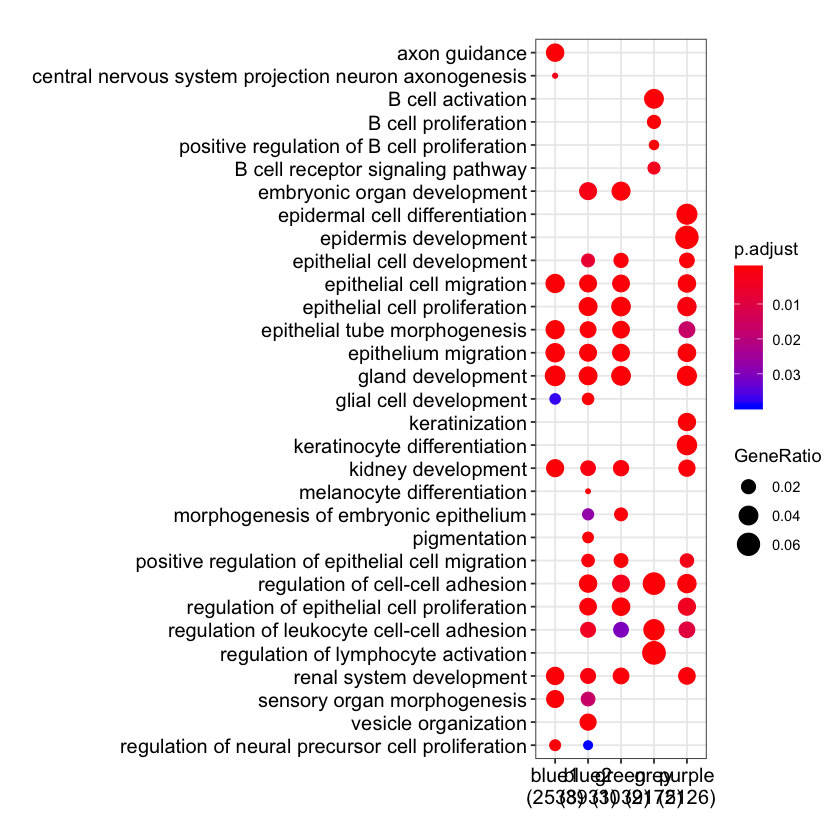

In [36]:
dotplot(ck_go_bp_sel,showCategory = 10)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups_sel.eps"),height=7, width=10)